## Libraries

In [59]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from random import shuffle
import cv2 as cv


import matplotlib.pyplot as plt

# model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Flatten, 
                                     Dense, 
                                     BatchNormalization, 
                                     Dropout
                                     )
from tensorflow.keras.optimizers import Adam

## Read the Data

In [ ]:
cur_dir = os.getcwd()

for root, dirs, files in os.walk(cur_dir):
    if "archive" in root:
        print(root, files)

In [3]:
img_path = "./archive/images/"
img_list = os.listdir(img_path)

In [4]:
def load_train_img(df):
    train_img = list()
    test_img = list()
    
    for _ in range(0, int(len(df) * 0.8)):
        try:
            label = df.label[_]
            img = cv.resize(cv.imread(df.path[_]), (64, 64))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            train_img.append([np.array(img) / 255.0, np.array(label)])
        except:
            pass
    for _ in range(int(len(df) * 0.8) + 1, len(df)):
        try:
            label = df.label[_]
            img = cv.resize(cv.imread(df.path[_]), (64, 64))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            test_img.append([np.array(img) / 255.0, np.array(label)])
        except:
            pass

    return train_img, test_img

In [51]:
df = pd.read_csv(cur_dir + "/archive/styles.csv").drop(columns = {"Unnamed: 10", "Unnamed: 11"})

In [52]:
### 필주님 전처리 ###

df.loc[df['subCategory'].isin(['Sandal', 'Flip Flops']), 'subCategory'] = 'Shoes'
df.loc[df['subCategory'].isin(['Dress']), 'subCategory'] = 'Topwear'
df2 = df[df['subCategory'].isin(['Topwear', 'Shoes', 'Bags','Bottomwear', 'Watches', 'Innerwear', 'Eyewear', 'Wallets', 'Belts'])]
label_df = df2[['id','subCategory']].rename(columns = {'subCategory':'label'})

In [53]:
### id에 맞는 path 를 dataframe 형식으로 만들기 ###
label_df["path"] = 0    
for _ in range(60000):
    try:
        label_df["path"][_] = img_path + str(label_df["id"][_]) + ".jpg"
    except:
        pass
label_df.drop(columns = "id", inplace = True)

### 라벨 인코딩 ###
label = label_encoder.fit_transform(label_df.label)
label_df["label"] = label

In [55]:
train_img, test_img = load_train_img(label_df)

In [57]:
print(f"=============\nDataset\n=============\ntrain: {len(train_img)}\ntest: {len(test_img)}")

Dataset
train: 26001
test: 6465


In [60]:
train_images = np.array([item[0] for item in train_img])
train_labels = np.array([item[1] for item in train_img])
test_images = np.array([item[0] for item in test_img])
test_labels = np.array([item[1] for item in test_img])

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(64).batch(128) 

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(1000)

model = Sequential([
    ### layer 1 ###
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 2 ###
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 3 ###
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 4 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 5 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 6 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
  
    Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(9, activation = 'softmax')
])

### 과적합으로 보여 추가 ###
optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, verbose = 1)

Epoch 1/10


204/204 [==============================] - 106s 509ms/step - loss: 14.6904 - accuracy: 0.8241 - val_loss: 13.9983 - val_accuracy: 0.3425
Epoch 2/10
204/204 [==============================] - 104s 508ms/step - loss: 11.0337 - accuracy: 0.9344 - val_loss: 10.2431 - val_accuracy: 0.7657
Epoch 3/10
204/204 [==============================] - 105s 514ms/step - loss: 8.1109 - accuracy: 0.9523 - val_loss: 6.9873 - val_accuracy: 0.9258
Epoch 4/10
204/204 [==============================] - 105s 513ms/step - loss: 5.9051 - accuracy: 0.9600 - val_loss: 5.0593 - val_accuracy: 0.9411
Epoch 5/10
204/204 [==============================] - 104s 508ms/step - loss: 4.2808 - accuracy: 0.9643 - val_loss: 3.6391 - val_accuracy: 0.9601
Epoch 6/10
204/204 [==============================] - 104s 511ms/step - loss: 3.1044 - accuracy: 0.9678 - val_loss: 2.6941 - val_accuracy: 0.9570
Epoch 7/10
204/204 [==============================] - 104s 509ms/step - loss: 2.2953 - accuracy: 0.9693 - val_loss: 1.

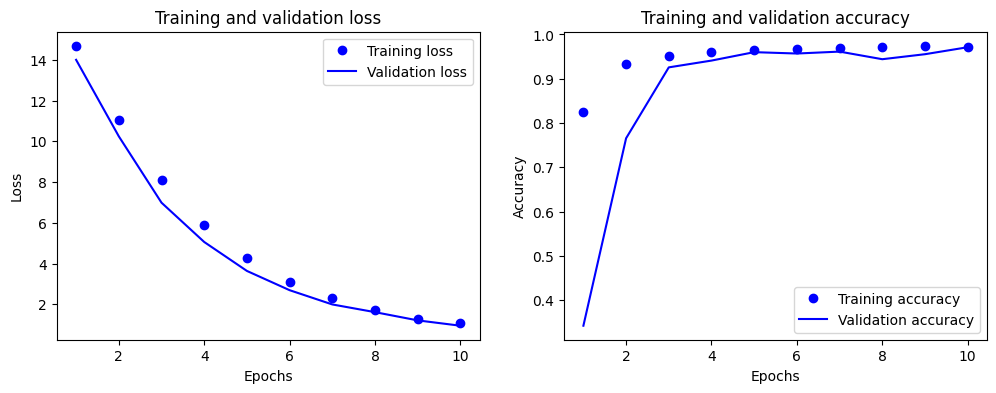

In [61]:
### 시각화 ###

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()